In [1]:
%load_ext autoreload
%autoreload 2

# add src to path
import sys
sys.path.append('/cluster/home/kheuto01/code/play-with-learning-army/src')
import numpy as np
# change directory to this files directory
import os
os.chdir('/cluster/home/kheuto01/code/play-with-learning-army')
from data_loader import load_processed, make_dataset, load_datasets
from embedder_registry import initialize_embedding, initialize_criteria_embedding, initialize_combiner
from domain_models import initialize_domain_models
from loss_opt import initialize_loss, initialize_optimizer
import torch
import yaml
import transformers
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score

In [2]:
def bootstrap_metric_across_domains(y_pred, y_true, metric_func, domain_ids):
    domain_metrics = {}
    unique_domains = np.unique(domain_ids)
    print(unique_domains)
    for d in unique_domains:
        d_idx = np.where(domain_ids == d)[0]
        domain_metrics[d] = {}
        mean,low,high,domain_metrics[d]['bootstrap_scores'] = bootstrap_metric(y_pred[d_idx], y_true[d_idx], metric_func)
        domain_metrics[d]['mean'] = mean
        domain_metrics[d]['error'] =(low,high)
    return domain_metrics

#https://github.com/tufts-ml/SupContrast/blob/tmlr/bootstrap_lin_acc.py
def bootstrap_metric(y_pred, y_true, metric_func,
                     n_bootstraps=1000, rng_seed=123):
    """Compute test set boostrapping of a metric
    Args:
        y_pred (tensor): Model predictions for some output y
        y_true (tensor): True value of output y
        metric_func (function): function with parameters (y_pred, y_true)
                                returning a Tensor castable metric
        n_bootstraps (int, optional): Number of bootstrap samples to take.
                                      Defaults to 200.
        rng_seed (int, optional): Random seed for reproducibility.
                                  Defaults to 123.
    Returns:
        tuple: metric_mean: Tensor with bootstrapped mean of metric
               ci_low: Low value from 95% confidence interval
               ci_high: High value from 95% confidence interval
               b_scores: Bootstrapped metric outputs
    """
    b_scores = None
    rng = torch.random.manual_seed(rng_seed)
    # bootstrap
    for _ in range(n_bootstraps):
        sample_idx = torch.randint(y_pred.shape[0], size=(y_pred.shape[0],), generator=rng)
        score = torch.Tensor([metric_func(y_pred[sample_idx], y_true[sample_idx])])
        # store results from each run along axis 0, with other axes' shape determined by metric
        if b_scores is None:
            b_scores = score.unsqueeze(0)
        else:
            b_scores = torch.vstack((b_scores, score))
    # compute mean and confidence interval
    metric_mean = torch.mean(b_scores, dim=0)
    ci_low = torch.quantile(b_scores, 0.025, dim=0)
    ci_high = torch.quantile(b_scores, 0.975, dim=0)
    return (metric_mean, ci_low, ci_high, b_scores)


def bootstrap_dif(b_scores_1, b_scores_2):
    """Examine the difference of two bootstrapped metrics

    Args:
        b_scores_1 (Tensor): Bootstrapped metric outputs, with same seed as 2
        b_scores_2 (Tensor): Bootstrapped metric outputs, with same seed as 1
    Returns:
        tensor: True if 95% CI does not contain 0 so result is statistically significant
                False if 95% CI contains 0 so result is not statistically significant
    """
    dif_scores = b_scores_1 - b_scores_2
    # compute confidence interval of the difference
    ci_low = torch.quantile(dif_scores, 0.025, dim=0)
    ci_high = torch.quantile(dif_scores, 0.975, dim=0)
    return ~torch.logical_and(ci_low <= 0, ci_high >= 0)

In [4]:
all_results = []
for experiment_directory in ['/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test15_lr5e-07_alpha0.001_beta0.1',
                             '/cluster/tufts/hugheslab/kheuto01/sensemaking/bow_frozen_test/test15_lr0.001_wd0.001_bs32',
                             '/cluster/tufts/hugheslab/kheuto01/sensemaking/bow_frozen_test/test15_lr0.01_wd0.001_bsN']:

    #experiment_directory = '/cluster/tufts/hugheslab/kheuto01/sensemaking/bertfinetune_test/test20_lr5e-07_alpha0.01_beta0.01'
    problem_config_path = '/cluster/home/kheuto01/code/play-with-learning-army/config/problem_config.yaml'
    test_metrics_path = os.path.join(experiment_directory, 'test_metrics.csv')
    config_path = os.path.join(experiment_directory, 'config.yaml')
    model_path = os.path.join(experiment_directory, 'final_model.pth')
    hyper_config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
    problem_config = yaml.load(open(problem_config_path, 'r'), Loader=yaml.FullLoader)
    num_domains = problem_config['num_domains']
    train_dataset =  load_datasets(hyper_config, train=True)[0]

    save_dict = torch.load(model_path, weights_only=False, map_location=torch.device('cpu'))
    domain_model_dict = save_dict['domain_model_dict']
    if 'embed_func' in save_dict:
        embedder = save_dict['embed_func']
    else:
        embedder = initialize_embedding(hyper_config, *train_dataset)
    embedder.device = 'cpu'

    processed_test_features, processed_test_labels = load_processed(hyper_config['test_x_file'], 
                                                                hyper_config['test_y_file'])
    (xs, ys, problem_ids, student_ids) = make_dataset(processed_test_features, processed_test_labels)
    xs, ys, problem_ids, student_ids = embedder.preprocess_data((xs, ys, torch.tensor(problem_ids), torch.tensor(student_ids)), hyper_config)

    all_preds, all_labels, all_weights, all_domains = [], [], [], []

    if isinstance(xs, transformers.BatchEncoding):
        batch_length = len(next(iter(xs.values())))
    else:
        batch_length = len(xs)
        
    for i in range(batch_length):
        if isinstance(xs, transformers.BatchEncoding):
            x = {k: v[i].unsqueeze(0) for k, v in xs.items()}
        else:
            x = xs[i].unsqueeze(0)
        y = ys[i]
        p = problem_ids[i]
        s = student_ids[i]

        x_embed = embedder.forward(x)

        criteria_counter = 0
        for d in range(num_domains):
            num_criteria = problem_config['problems'][p]['domains'][d]["num_criteria"]
            for c in range(num_criteria):
                c_embed = torch.tensor([c])
                final_representation = torch.cat((x_embed, c_embed.unsqueeze(0)), dim=1)
                y_pred = domain_model_dict[d](final_representation)
                weight = 1/num_criteria

                all_preds.append(y_pred.detach().cpu().numpy())
                all_labels.append(y[criteria_counter].cpu().numpy())
                all_weights.append(weight)
                all_domains.append(d)
                criteria_counter += 1

    all_preds_np = np.concatenate(all_preds).flatten()
    all_labels_np = np.array(all_labels).flatten()
    all_labels = torch.tensor(np.array(all_labels)).squeeze()
    all_preds = torch.tensor(all_preds).squeeze()

    domain_auprc = bootstrap_metric_across_domains(all_labels, all_preds, average_precision_score, all_domains)
    micro_auprc, micro_auprc_low, micro_auprc_high, micro_auprc_scores = bootstrap_metric(all_labels, all_preds, average_precision_score)
    print(f'Micro AUPRC: {micro_auprc} [{micro_auprc_low}, {micro_auprc_high}]')
    results = [(domain_auprc[d]['mean'], domain_auprc[d]['error']) for d in range(8)]

    all_results.append(results)


[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

Micro AUPRC: tensor([0.8618]) [tensor([0.8231]), tensor([0.8966])]
[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

Micro AUPRC: tensor([0.8292]) [tensor([0.7865]), tensor([0.8689])]
[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

Micro AUPRC: tensor([0.8580]) [tensor([0.8169]), tensor([0.8945])]


In [47]:
fine_results = all_results[0]
bow_results = all_results[1]
frozen_results = all_results[2]

# convert all tensors to scalars
fine_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in fine_results]
bow_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in bow_results]
frozen_results = [(mean.item(), (low.item(), high.item())) for mean, (low, high) in frozen_results]

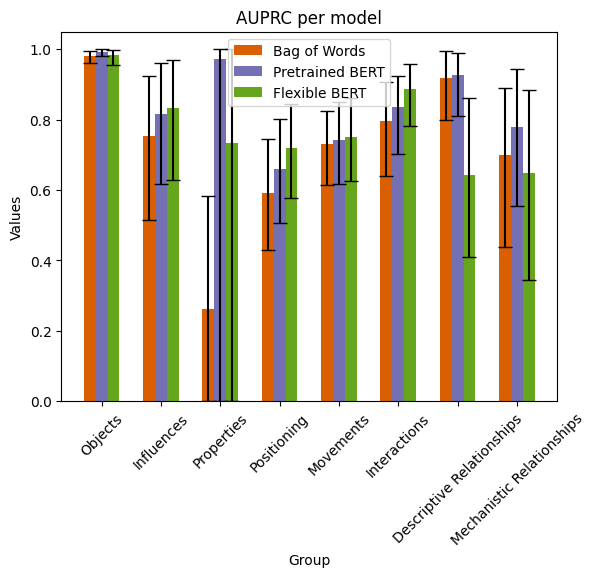

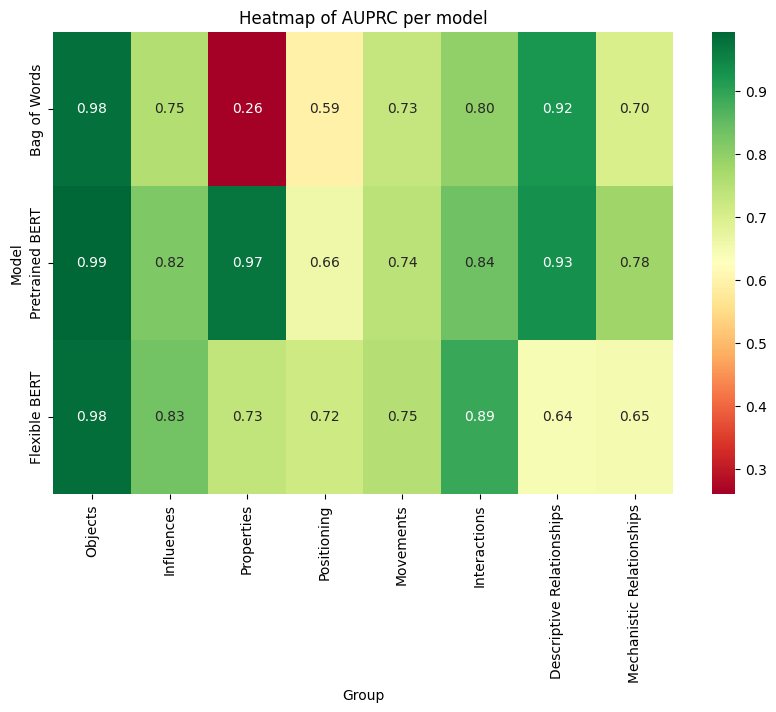

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_grouped_bar_chart(list1, list2, list3):
    # Extract means and error bars
    means1, lows1, highs1 = zip(*[(mean, low, high) for mean, (low, high) in list1])
    means2, lows2, highs2 = zip(*[(mean, low, high) for mean, (low, high) in list2])
    means3, lows3, highs3 = zip(*[(mean, low, high) for mean, (low, high) in list3])

    # Calculate error bars
    errors1 = [np.array(means1) - np.array(lows1), np.array(highs1) - np.array(means1)]
    errors2 = [np.array(means2) - np.array(lows2), np.array(highs2) - np.array(means2)]
    errors3 = [np.array(means3) - np.array(lows3), np.array(highs3) - np.array(means3)]

    # X locations for the groups
    ind = np.arange(len(means1))
    width = 0.2

    fig, ax = plt.subplots()

    # Plot bars with error bars
    bar1 = ax.bar(ind - width, means1, width, yerr=errors1, label='Bag of Words', capsize=5, color='#d95f02')
    bar2 = ax.bar(ind, means2, width, yerr=errors2, label='Pretrained BERT', capsize=5, color='#7570b3')
    bar3 = ax.bar(ind + width, means3, width, yerr=errors3, label='Flexible BERT', capsize=5, color='#66a61e')

    # Add labels and title
    ax.set_xlabel('Group')
    ax.set_ylabel('Values')
    ax.set_title('AUPRC per model')
    ax.set_xticks(ind)
    ax.set_xticklabels(['Objects', 'Influences', 'Properties', 'Positioning', 'Movements', 'Interactions', 'Descriptive Relationships', 'Mechanistic Relationships'])
    ax.legend()

    # Rotate x tick labels
    ax.tick_params(axis='x', rotation=45)

    plt.show()

def plot_heatmap(list1, list2, list3):
    # Extract means
    means1 = [mean for mean, _ in list1]
    means2 = [mean for mean, _ in list2]
    means3 = [mean for mean, _ in list3]

    # Combine means into a single array
    data = np.array([means1, means2, means3])

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="RdYlGn", cbar=True, xticklabels=['Objects', 'Influences', 'Properties', 'Positioning', 'Movements', 'Interactions', 'Descriptive Relationships', 'Mechanistic Relationships'], yticklabels=['Bag of Words', 'Pretrained BERT', 'Flexible BERT'], ax=ax)

    # Add labels and title
    ax.set_xlabel('Group')
    ax.set_ylabel('Model')
    ax.set_title('Heatmap of AUPRC per model')

    plt.show()


# Plot the chart
plot_grouped_bar_chart(bow_results, frozen_results, fine_results)
plot_heatmap(bow_results, frozen_results, fine_results)


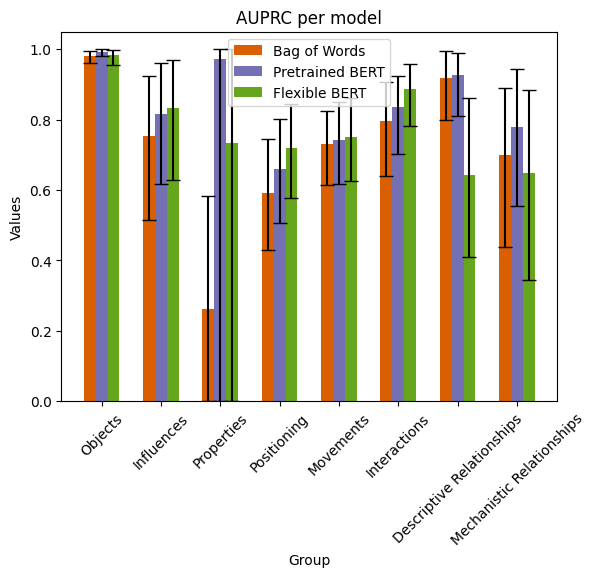

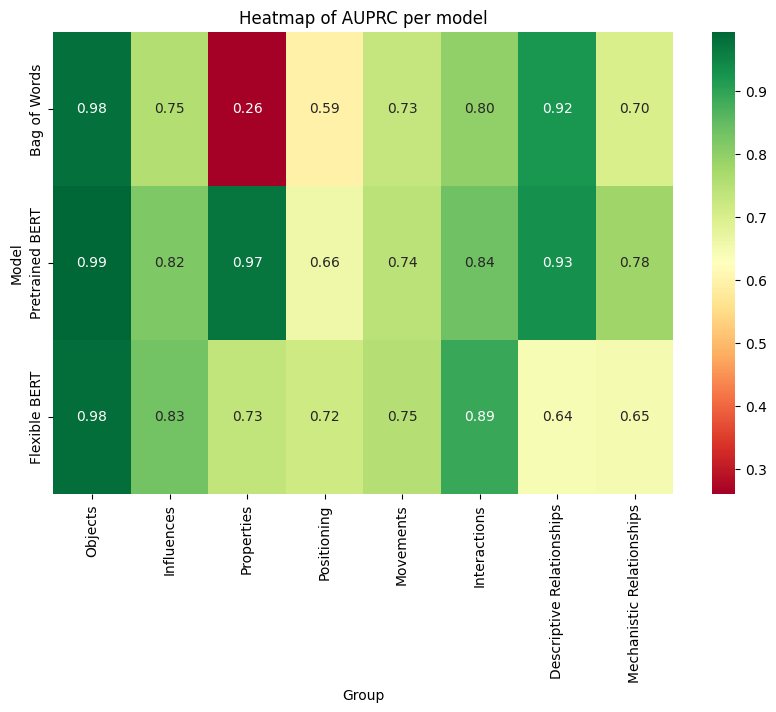

In [53]:
import random

def jitter_results(results, jitter_amount=0.05):
    jittered_results = []
    for mean, (low, high) in results:
        jitter = random.uniform(-jitter_amount, jitter_amount)
        jittered_mean = mean + jitter
        jittered_low = low + jitter
        jittered_high = high + jitter
        jittered_results.append((jittered_mean, (jittered_low, jittered_high)))
    return jittered_results

# Jitter the bow_results to create frozen_results and fine_results
jittered_frozen_results = jitter_results(fine_results)
jittered_bow_results = jitter_results(fine_results)

# Plot the chart
plot_grouped_bar_chart(bow_results, frozen_results, fine_results)
plot_heatmap(bow_results, frozen_results, fine_results)

/tmp/ipykernel_67331/3493828882.py:37: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  all_preds = torch.tensor(all_preds).squeeze()


[0 1 2 3 4 5 6 7]


/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/learningarmy/lib/pytho

In [23]:
all_domain_properties = problem_config['problems'][0]['domains']
for d in range(num_domains):
    print(f"Domain {all_domain_properties[d]['name']}")
    print(f"AUPRC: {domain_auprc[d]['mean']} +/- {domain_auprc[d]['std_err']}")
    print(f"Properties: {all_domain_properties[d]}")
    print("\n")

Domain Objects
AUPRC: 0.9810370802879333 +/- 0.0002727298706304282
Properties: {'name': 'Objects', 'num_criteria': 1}


Domain Influences
AUPRC: 0.7538266777992249 +/- 0.0034001218155026436
Properties: {'name': 'Influences', 'num_criteria': 0}


Domain Properties
AUPRC: 0.26074010133743286 +/- 0.004316782113164663
Properties: {'name': 'Properties', 'num_criteria': 0}


Domain Positioning
AUPRC: 0.5927468538284302 +/- 0.00258074258454144
Properties: {'name': 'Positioning', 'num_criteria': 1}


Domain Movements
AUPRC: 0.7294201850891113 +/- 0.0017002575332298875
Properties: {'name': 'Movements', 'num_criteria': 3}


Domain Interactions
AUPRC: 0.796755313873291 +/- 0.002122317673638463
Properties: {'name': 'Interactions', 'num_criteria': 0}


Domain Descriptive Relationships
AUPRC: 0.9196606874465942 +/- 0.0016667635645717382
Properties: {'name': 'Descriptive Relationships', 'num_criteria': 2}


Domain Mechanistic Relationships
AUPRC: 0.7001209259033203 +/- 0.0036547211930155754
Propertie

In [24]:
print(f'micro_auprc: {micro_auprc} ({micro_auprc_low}, {micro_auprc_high})')

micro_auprc: tensor([0.8292]) (tensor([0.7865]), tensor([0.8689]))
